In [1]:
# ------------------------------------------------------------
# Proxy setup (DWD): ofsquid.dwd.de:8080
# ------------------------------------------------------------
import os

proxy = "http://ofsquid.dwd.de:8080"

os.environ["http_proxy"]  = proxy
os.environ["https_proxy"] = proxy
os.environ["HTTP_PROXY"]  = proxy
os.environ["HTTPS_PROXY"] = proxy
os.environ["NO_PROXY"]    = "localhost,127.0.0.1,::1"

print("Proxy set to:", proxy)
print("NO_PROXY:", os.environ["NO_PROXY"])

Proxy set to: http://ofsquid.dwd.de:8080
NO_PROXY: localhost,127.0.0.1,::1


In [2]:
# ============================================================
# Notebook 01 — Create synthetic EU forecast and write to Zarr
# ============================================================

import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["font.size"] = 11


In [3]:
# ------------------------------------------------------------
# EU domain grid (coarse but realistic for a demo)
# ------------------------------------------------------------

# Europe box
lat = np.linspace(35.0, 72.0, 121)    # 121 points
lon = np.linspace(-15.0, 35.0, 181)   # 181 points

# forecast lead times
init_time = np.datetime64("2026-01-10T00:00")
lead_hours = np.arange(0, 121, 3)  # 0..120h every 3h
valid_time = init_time + lead_hours.astype("timedelta64[h]")

lat2d, lon2d = np.meshgrid(lat, lon, indexing="ij")

print("Grid:", lat.size, "x", lon.size)
print("Lead times:", lead_hours.size, "steps")


Grid: 121 x 181
Lead times: 41 steps


In [4]:
# ------------------------------------------------------------
# Synthetic "forecast model": smooth fronts + advection + noise
# ------------------------------------------------------------

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def gaussian2d(lat2d, lon2d, lat0, lon0, sig_lat=4.0, sig_lon=6.0):
    return np.exp(-0.5*((lat2d-lat0)/sig_lat)**2 - 0.5*((lon2d-lon0)/sig_lon)**2)

def synth_fields(lat2d, lon2d, t, rng):
    """
    Create realistic-looking fields:
    - t2m: north-south gradient + moving front + warm blob
    - mslp: low-pressure system moving east
    - wind: geostrophic-like flow around low
    - tp: precip along front band (accum later)
    """
    # normalize coords
    y = (lat2d - 35.0) / (72.0 - 35.0)   # 0..1
    x = (lon2d + 15.0) / (35.0 + 15.0)   # 0..1

    # time scaling (in "model units")
    tau = t / 40.0

    # moving front line (diagonal, advecting east)
    front = (x - 0.25 - 0.015*t) + 0.7*(y - 0.45)
    front_band = np.exp(-(front/0.05)**2)

    # temperature base (°C)
    t_base = 18.0 - 18.0*y                      # warm south, cold north
    t_wave = 2.0*np.sin(2*np.pi*(x + 0.25*y - 0.02*t))
    t_front = 4.0*(sigmoid(-front*40.0) - 0.5)  # step across front
    t_blob = 3.5*gaussian2d(lat2d, lon2d, 45.0 + 2*np.sin(tau), 5.0 + 8*np.cos(tau))

    t2m = t_base + t_wave + t_front + t_blob
    t2m += 0.02*rng.standard_normal(t2m.shape)  # mild noise

    # pressure (hPa): moving low
    low_lat = 55.0 + 2.0*np.sin(0.1*t)
    low_lon = -5.0 + 0.25*t
    low = gaussian2d(lat2d, lon2d, low_lat, low_lon, sig_lat=6.0, sig_lon=8.0)
    mslp = 1015.0 - 25.0*low + 2.0*np.cos(2*np.pi*(x+y))

    # wind (m/s): crude circulation around low + background westerlies
    dlat = (lat2d - low_lat)
    dlon = (lon2d - low_lon)
    r2 = dlat**2 + (dlon*1.3)**2 + 6.0

    u10 = 6.0 + 40.0 * (-dlat) / r2   # eastward mean + swirl
    v10 =        40.0 * ( dlon) / r2

    # precip rate (mm/3h): mainly along front band
    tp_rate = 2.0*front_band*(0.5 + 0.5*np.cos(2*np.pi*(x-0.02*t)))
    tp_rate = np.clip(tp_rate, 0.0, None)
    tp_rate += 0.01*np.abs(rng.standard_normal(tp_rate.shape))
    tp_rate = np.clip(tp_rate, 0.0, None)

    return t2m, u10, v10, mslp, tp_rate


In [5]:
# ------------------------------------------------------------
# Create forecast dataset
# ------------------------------------------------------------

rng = np.random.default_rng(42)

nt = lead_hours.size
ny, nx = lat2d.shape

t2m  = np.empty((nt, ny, nx), dtype=np.float32)
u10  = np.empty((nt, ny, nx), dtype=np.float32)
v10  = np.empty((nt, ny, nx), dtype=np.float32)
mslp = np.empty((nt, ny, nx), dtype=np.float32)
tp_rate = np.empty((nt, ny, nx), dtype=np.float32)

for i, h in enumerate(lead_hours):
    t2m[i], u10[i], v10[i], mslp[i], tp_rate[i] = synth_fields(lat2d, lon2d, h, rng)

# precipitation accumulation (mm)
tp_acc = np.cumsum(tp_rate, axis=0)  # per 3h step

lead_time_td = lead_hours.astype("timedelta64[h]")

ds = xr.Dataset(
    data_vars=dict(
        t2m=(("valid_time", "lat", "lon"), t2m,  {"units": "degC", "long_name": "2m temperature"}),
        u10=(("valid_time", "lat", "lon"), u10,  {"units": "m s-1", "long_name": "10m zonal wind"}),
        v10=(("valid_time", "lat", "lon"), v10,  {"units": "m s-1", "long_name": "10m meridional wind"}),
        mslp=(("valid_time", "lat", "lon"), mslp,{"units": "hPa", "long_name": "mean sea level pressure"}),
        tp=(("valid_time", "lat", "lon"), tp_acc,{"units": "mm", "long_name": "total precipitation (accum)"}),
    ),
    coords=dict(
        init_time=init_time,
        valid_time=("valid_time", valid_time),
        lead_time=("valid_time", lead_time_td, {"long_name": "forecast lead time"}),
        lat=("lat", lat, {"units": "degrees_north"}),
        lon=("lon", lon, {"units": "degrees_east"}),
    ),
    attrs=dict(
        title="Synthetic European Forecast Demo",
        institution="Demo dataset for Zarr tutorial",
        history="Created in Notebook 04",
    ),
)

ds

<xarray.Dataset> Size: 18MB
Dimensions:     (valid_time: 41, lat: 121, lon: 181)
Coordinates:
  * valid_time  (valid_time) datetime64[s] 328B 2026-01-10 ... 2026-01-15
  * lat         (lat) float64 968B 35.0 35.31 35.62 35.92 ... 71.38 71.69 72.0
  * lon         (lon) float64 1kB -15.0 -14.72 -14.44 ... 34.44 34.72 35.0
    init_time   datetime64[s] 8B 2026-01-10
    lead_time   (valid_time) timedelta64[s] 328B 00:00:00 ... 5 days 00:00:00
Data variables:
    t2m         (valid_time, lat, lon) float32 4MB 20.01 20.05 ... 0.3478 0.3995
    u10         (valid_time, lat, lon) float32 4MB 7.391 7.414 ... 4.532 4.559
    v10         (valid_time, lat, lon) float32 4MB -0.6957 -0.6874 ... 0.7974
    mslp        (valid_time, lat, lon) float32 4MB 1.017e+03 ... 1.017e+03
    tp          (valid_time, lat, lon) float32 4MB 0.01203 0.002933 ... 0.4222
Attributes:
    title:        Synthetic European Forecast Demo
    institution:  Demo dataset for Zarr tutorial
    history:      Created in Notebook 04

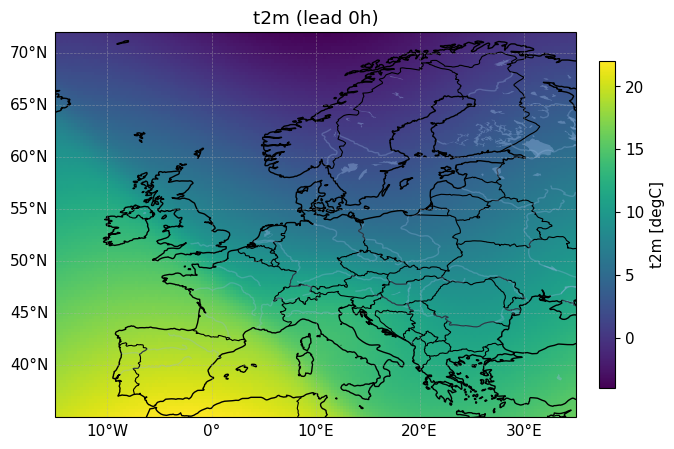

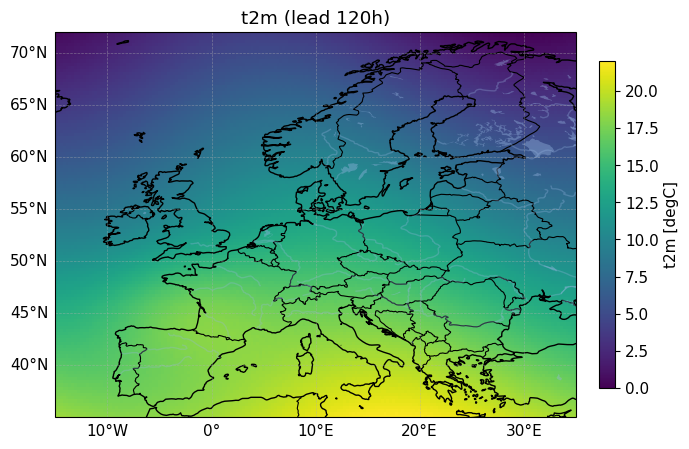

In [6]:
# ------------------------------------------------------------
# Quick look on a Cartopy map: first and last lead time
# ------------------------------------------------------------

import matplotlib.pyplot as plt

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
except ImportError as e:
    raise ImportError(
        "Cartopy is not installed. Install with:\n"
        "  pip install cartopy\n"
        "or (conda):\n"
        "  conda install -c conda-forge cartopy"
    ) from e


def plot_field_cartopy(da, title, no=''):
    """
    Plot a lat/lon field on a Cartopy PlateCarree map.
    """
    proj = ccrs.PlateCarree()

    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=proj)

    # map extent (Europe)
    ax.set_extent([-15, 35, 35, 72], crs=proj)

    # features
    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=1.0)
    ax.add_feature(cfeature.BORDERS.with_scale("50m"), linewidth=0.8)
    ax.add_feature(cfeature.LAKES.with_scale("50m"), alpha=0.4)
    ax.add_feature(cfeature.RIVERS.with_scale("50m"), alpha=0.3)

    # gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle="--")
    gl.top_labels = False
    gl.right_labels = False

    # plot
    im = ax.pcolormesh(
        ds["lon"].values,
        ds["lat"].values,
        da.values,
        shading="auto",
        transform=proj,
    )

    ax.set_title(title)
    cb = plt.colorbar(im, ax=ax, shrink=0.85, pad=0.03)
    cb.set_label(f"{da.name} [{da.attrs.get('units','')}]")

    plt.savefig(f"zarr_ex_field_{no}")
    plt.show()


plot_field_cartopy(ds["t2m"].isel(valid_time=0),  "t2m (lead 0h)","000")
plot_field_cartopy(ds["t2m"].isel(valid_time=-1), "t2m (lead 120h)","120")


In [7]:
# ------------------------------------------------------------
# Zarr write
# ------------------------------------------------------------

OUTDIR = "data"
os.makedirs(OUTDIR, exist_ok=True)

ZARR_PATH = os.path.join(OUTDIR, "demo_eu_forecast.zarr")

# Zarr best practice: chunk so point extraction is fast
# - time chunk = 1 (fast timeseries reading)
# - lat/lon chunks ~ moderate
chunked = ds.chunk({"valid_time": 1, "lat": 60, "lon": 60})

# overwrite if exists
if os.path.exists(ZARR_PATH):
    import shutil
    shutil.rmtree(ZARR_PATH)

chunked.to_zarr(ZARR_PATH, mode="w", consolidated=True)
print("Wrote:", ZARR_PATH)

/Users/rpotthas/ropy/lib/python3.12/site-packages/zarr/api/asynchronous.py:247: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Wrote: data/demo_eu_forecast.zarr
